Imports

In [26]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import matplotlib.pyplot as plt


Load dataset

In [27]:
df = pd.read_csv("../dataset/iSWAI_HistoryData.csv")

In [28]:
df.head()

,name,datetime,temp,humidity,precip,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,stations,source
0,"talisay, daanbantayan, cebu",2022-01-01T00:00:00,25.9,80.56,4.0,43.9,30.2,34.5,1015.0,100.0,NaN,remote,obs
1,"talisay, daanbantayan, cebu",2022-01-01T01:00:00,25.9,81.05,3.8,44.6,28.8,34.2,1014.0,100.0,NaN,remote,obs
2,"talisay, daanbantayan, cebu",2022-01-01T02:00:00,26.1,80.59,2.8,56.9,31.0,40.2,1014.0,100.0,NaN,remote,obs
3,"talisay, daanbantayan, cebu",2022-01-01T03:00:00,26.6,79.20,4.7,43.2,34.2,49.2,1013.0,100.0,NaN,remote,obs
4,"talisay, daanbantayan, cebu",2022-01-01T04:00:00,26.6,79.20,3.1,48.2,38.5,60.7,1013.0,100.0,NaN,remote,obs


In [29]:
df.columns

Index(['name', 'datetime', 'temp', 'humidity', 'precip', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'stations', 'source'],
      dtype='str')

In [30]:
df.shape

(35064, 13)

Parse datetime + create datetime features
- This is the “include datetime in features” part.

In [31]:
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df = df.sort_values("datetime").reset_index(drop=True)

Create Target (Next Hour)
This means:

Row at 10:00 → predicts windspeed at 11:00

In [32]:
df["target_windspeed"] = df["windspeed"].shift(-1)

Create Strong Lag Features and Rolling Features
- Adding the rolling features, can make These capture short-term patterns and turbulence.

In [33]:
lags = [1,2,3,6,12,24]

for lag in lags:
    df[f"wind_lag_{lag}"] = df["windspeed"].shift(lag)
    df[f"gust_lag_{lag}"] = df["windgust"].shift(lag)

windows = [3,6,12,24]

for w in windows:
    df[f"wind_roll_mean_{w}"] = df["windspeed"].rolling(w).mean()
    df[f"wind_roll_std_{w}"] = df["windspeed"].rolling(w).std()

Basic Time Features

In [34]:
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek  # 0=Mon
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day

Cyclical encoding 
-better than raw hour/month

In [36]:
df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)

df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12)

In [37]:
df[["datetime","hour","dayofweek","month","hour_sin","hour_cos"]].head()

,datetime,hour,dayofweek,month,hour_sin,hour_cos
0,2022-01-01 00:00:00,0,5,1,0.000000,1.000000
1,2022-01-01 01:00:00,1,5,1,0.258819,0.965926
2,2022-01-01 02:00:00,2,5,1,0.500000,0.866025
3,2022-01-01 03:00:00,3,5,1,0.707107,0.707107
4,2022-01-01 04:00:00,4,5,1,0.866025,0.500000


SELECTION OF FEATURES AND TARGET PREDICTED VARIABLE
- We’ll use your weather columns + datetime features + Create Strong Lag Features + Rolling Features

In [ ]:
lag_features = [col for col in df.columns if "lag" in col]
rolling_features = [col for col in df.columns if "roll" in col]
feature_cols = [
    "temp", "humidity", "precip", "windgust", "winddir",
    "sealevelpressure", "cloudcover",
    # datetime-based features
    "dayofweek", "day", "hour_sin", "hour_cos", "month_sin", "month_cos"
] + lag_features + rolling_features

Make sure cols exist, then drop rows with missing in required cols

In [39]:
use_cols = ["datetime", "target_windspeed"] + feature_cols
df2 = df[use_cols].dropna().copy()

In [40]:
X = df2[feature_cols].to_numpy()
y = df2["target_windspeed"].to_numpy()

In [41]:
df2.shape, X.shape, y.shape

((35038, 35), (35038, 33), (35038,))

DISPLAY iF DATETIME IS PRESENT!!!!

In [56]:
df2.head()

,datetime,target_windspeed,temp,humidity,precip,windgust,winddir,sealevelpressure,cloudcover,dayofweek,...,wind_lag_24,gust_lag_24,wind_roll_mean_3,wind_roll_std_3,wind_roll_mean_6,wind_roll_std_6,wind_roll_mean_12,wind_roll_std_12,wind_roll_mean_24,wind_roll_std_24
24,2022-01-02 00:00:00,39.2,26.5,77.75,0.1,54.0,37.9,1014.0,95.9,6,...,30.2,43.9,40.333333,1.331666,41.700000,1.723949,42.608333,1.712764,38.620833,5.022296
25,2022-01-02 01:00:00,39.6,26.4,78.21,0.1,52.9,37.6,1014.0,97.2,6,...,28.8,44.6,39.466667,0.461880,41.033333,1.799630,42.391667,1.969522,39.054167,4.566035
26,2022-01-02 02:00:00,41.0,26.3,78.20,0.2,53.6,38.0,1013.0,99.7,6,...,31.0,56.9,39.333333,0.230940,40.433333,1.509525,42.150000,2.126670,39.412500,4.231693
27,2022-01-02 03:00:00,42.1,26.1,80.59,0.2,55.1,41.5,1012.0,96.5,6,...,34.2,43.2,39.933333,0.945163,40.133333,1.055778,41.875000,2.034755,39.695833,4.092887
28,2022-01-02 04:00:00,42.1,26.0,82.05,0.2,56.9,47.0,1012.0,99.1,6,...,38.5,48.2,40.900000,1.252996,40.183333,1.153112,41.691667,1.890386,39.845833,4.113073


Time-Based Split
This avoids leakage from future → past (important for forecasting).

In [43]:
split = int(len(df2) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

dt_test = df2["datetime"].iloc[split:].reset_index(drop=True)

In [44]:
len(X_train), len(X_test)

(28030, 7008)

TRAIN RANDOM FOREST

In [45]:
rf = RandomForestRegressor(
    n_estimators=800,
    max_depth=18,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

TRAIN XGBOOST

In [48]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1200,
    learning_rate=0.02,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.2,
    reg_alpha=0.2,
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

Ensemble (weighted, based on validation R²)

Instead of simple average, we weight the better model more.

In [49]:
def get_metrics(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> MAE: {mae:.4f} | RMSE: {rmse:.4f} | R2: {r2:.4f}")
    return mae, rmse, r2

In [57]:
_, _, r2_rf  = get_metrics(y_test, rf_pred,  "Random Forest")
_, _, r2_xgb = get_metrics(y_test, xgb_pred, "XGBoost")
_, _, r2_ens = get_metrics(y_test, (rf_pred + xgb_pred)/2, "Ensemble")

Random Forest -> MAE: 1.4600 | RMSE: 1.9821 | R2: 0.9436
XGBoost -> MAE: 1.4191 | RMSE: 1.9743 | R2: 0.9441
Ensemble -> MAE: 1.4104 | RMSE: 1.9402 | R2: 0.9460


Convert R2 to weights (clip to avoid negative weights)

In [51]:
w_rf  = max(r2_rf, 0)
w_xgb = max(r2_xgb, 0)
if (w_rf + w_xgb) == 0:
    w_rf, w_xgb = 0.5, 0.5
else:
    s = w_rf + w_xgb
    w_rf, w_xgb = w_rf/s, w_xgb/s

ens_pred = w_rf * rf_pred + w_xgb * xgb_pred
get_metrics(y_test, ens_pred, f"Ensemble (w_rf={w_rf:.2f}, w_xgb={w_xgb:.2f})")

Ensemble (w_rf=0.50, w_xgb=0.50) -> MAE: 1.4104 | RMSE: 1.9402 | R2: 0.9460


(1.41039537703959, np.float64(1.9401566044981071), 0.946005572863622)

Create results dataframe (datetime + actual + preds)

In [52]:
results = pd.DataFrame({
    "datetime": dt_test,
    "actual_windspeed": y_test,
    "rf_pred": rf_pred,
    "xgb_pred": xgb_pred,
    "ens_pred": ens_pred
})
results.head()

,datetime,actual_windspeed,rf_pred,xgb_pred,ens_pred
0,2025-03-14 23:00:00,27.4,28.132146,28.028484,28.080302
1,2025-03-15 00:00:00,26.3,27.060217,26.572721,26.816412
2,2025-03-15 01:00:00,25.6,25.446593,25.488037,25.467319
3,2025-03-15 02:00:00,25.6,25.114188,24.958902,25.036526
4,2025-03-15 03:00:00,25.6,25.764454,25.308485,25.536416


In [53]:
results.shape

(7008, 5)

Plot actual vs ensemble (datetime x-axis)

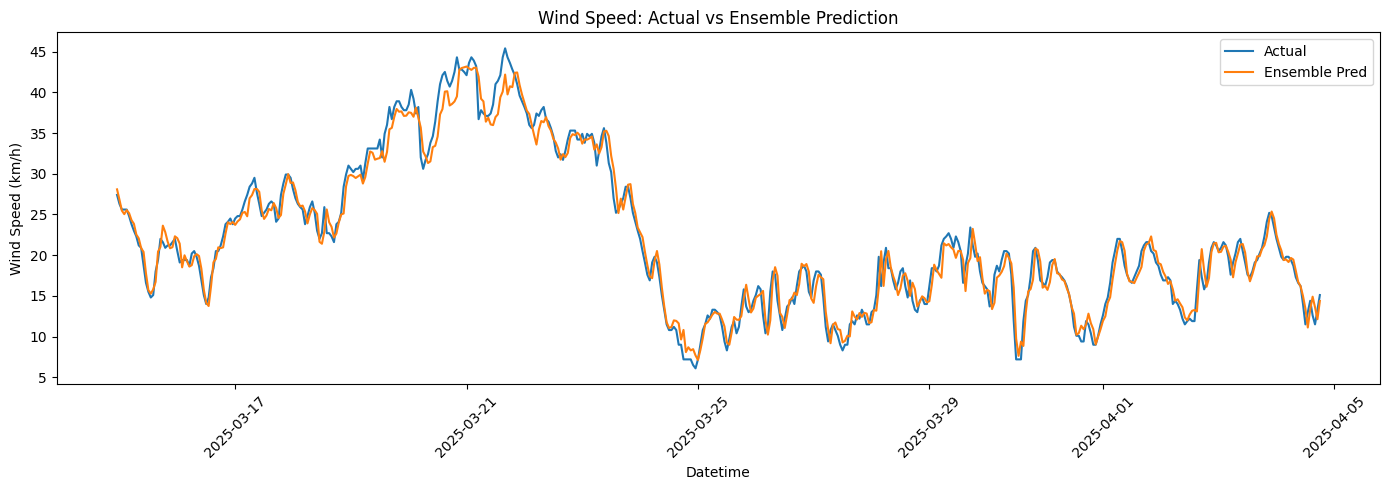

In [58]:
plt.figure(figsize=(14,5))
plot_n = 500  # show first 500 test points
plt.plot(results["datetime"][:plot_n], results["actual_windspeed"][:plot_n], label="Actual")
plt.plot(results["datetime"][:plot_n], results["ens_pred"][:plot_n], label="Ensemble Pred")
plt.title("Wind Speed: Actual vs Ensemble Prediction")
plt.xlabel("Datetime")
plt.ylabel("Wind Speed (km/h)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Save models for FastAPI

In [55]:
import joblib, os
os.makedirs("../server/models", exist_ok=True)
joblib.dump(
    {
        "rf": rf,
        "xgb": xgb_model,
        "feature_cols": feature_cols,
        "weights": {"rf": w_rf, "xgb": w_xgb}
    },
    "../server/models/windspeed_model.joblib"
)

print("Saved: ../server/models/windspeed_model.joblib")

Saved: ../server/models/windspeed_model.joblib
